# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Understand batching for a recurrent neural network, and develop custom Dataset and DataLoaders with collate_fn to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here.

https://colab.research.google.com/drive/1W28pRIE5P1FNhKPEpexGPvLw6XtaZfOg?usp=sharing

If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
# take a look at the file (first 5 lines)
with open('SMSSpamCollection', encoding='latin-1') as f:
    for i in range(5):
        line = f.readline()
        print(line.strip())


ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though


In [ ]:
spam_example = None
ham_example = None

for line in open('SMSSpamCollection', encoding='latin-1'):
    label, message = line.strip().split('\t')
    if label == 'spam' and spam_example is None:
        spam_example = message
    elif label == 'ham' and ham_example is None:
        ham_example = message
    if spam_example and ham_example:
        break

print("Spam Example:\nLabel: 'spam'\nMessage:", spam_example)
print("\nNon-spam Example:\nLabel: 'ham'\nMessage:", ham_example)


Spam Example:
Label: 'spam'
Message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Non-spam Example:
Label: 'ham'
Message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam_count = 0
ham_count = 0

for line in open('SMSSpamCollection', encoding='latin-1'):
    label, _ = line.strip().split('\t')
    if label == 'spam':
        spam_count += 1
    elif label == 'ham':
        ham_count += 1

print("Number of spam messages:", spam_count)
print("Number of non-spam (ham) messages:", ham_count)


Number of spam messages: 747
Number of non-spam (ham) messages: 4827


### Part (c) [4 pt]

load and parse the data into two lists: sequences and labels. Create character-level stoi and itos dictionaries. Reserve the index 0 for padding. Convert the sequences to list of character ids using stoi dictionary and convert the labels to a list of 0s and 1s by assinging class "ham" to 0 and class "spam" to 1.

In [ ]:
from collections import defaultdict

# 1. store raw text and labels
raw_texts = []
labels = []

with open('SMSSpamCollection', encoding='latin-1') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) != 2:
            continue
        label_str, message = parts
        raw_texts.append(message)
        labels.append(1 if label_str == 'spam' else 0)

# 2 - build character dictionaries
char_set = set(char for text in raw_texts for char in text)
char_list = sorted(char_set)

stoi = {ch: idx+1 for idx, ch in enumerate(char_list)}  # start from 1
stoi['<pad>'] = 0  # 0 padding
itos = {idx: ch for ch, idx in stoi.items()}

# 3. Convert each msg into a list of character IDs
sequences = [[stoi[char] for char in msg] for msg in raw_texts]

### test: check first few results
print("First sequence:", sequences[0])
print("First label:", labels[0])
print("First few stoi entries:", list(stoi.items())[:10])


First sequence: [40, 79, 1, 85, 78, 84, 73, 76, 1, 74, 85, 82, 79, 78, 71, 1, 80, 79, 73, 78, 84, 13, 1, 67, 82, 65, 90, 89, 15, 15, 1, 34, 86, 65, 73, 76, 65, 66, 76, 69, 1, 79, 78, 76, 89, 1, 73, 78, 1, 66, 85, 71, 73, 83, 1, 78, 1, 71, 82, 69, 65, 84, 1, 87, 79, 82, 76, 68, 1, 76, 65, 1, 69, 1, 66, 85, 70, 70, 69, 84, 15, 15, 15, 1, 36, 73, 78, 69, 1, 84, 72, 69, 82, 69, 1, 71, 79, 84, 1, 65, 77, 79, 82, 69, 1, 87, 65, 84, 15, 15, 15]
First label: 0
First few stoi entries: [(' ', 1), ('!', 2), ('"', 3), ('#', 4), ('$', 5), ('%', 6), ('&', 7), ("'", 8), ('(', 9), (')', 10)]


### Part (d) [4 pt]

Use train_test_split function from sklearn (https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) to split the data indices into `train`, `valid`, and `test`. Use a 60-20-20 split.

You saw in part (b) that there are many more non-spam messages than spam messages. This **imbalance** in our training data will be problematic for training. We can fix this disparity by duplicating spam messages in the training set, so that the training set is roughly balanced.

In [ ]:
from sklearn.model_selection import train_test_split

# index list
x = sequences
y = labels

indices = list(range(len(x)))  # x = sequences

# split to train and temp (60/40)
train_index, temp_index = train_test_split(indices, test_size=0.4, random_state=42, stratify=y)
# split to val and test (20/20)
val_index, test_index = train_test_split(temp_index, test_size=0.5, random_state=42, stratify=[y[i] for i in temp_index])


train_x = [x[idx] for idx in train_index]
train_y = [y[idx] for idx in train_index]
val_x = [x[idx] for idx in val_index]
val_y = [y[idx] for idx in val_index]
test_x = [x[idx] for idx in test_index]
test_y = [y[idx] for idx in test_index]

#Balance the train classes
train_spam = []
for idx, item in enumerate(train_x):
    if train_y[idx] == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_x = train_x + train_spam * 6
train_y = train_y + [1] * (len(train_spam) * 6)



In [ ]:
### TEST: Print number of samples in each split
print(f"Train size (before balancing): {len(train_index)}")
print(f"Validation size: {len(val_index)}")
print(f"Test size: {len(test_index)}")


Train size (before balancing): 3344
Validation size: 1115
Test size: 1115


### Part (e) [4 pt]

Since each sequence has a different length, we cannot use the default DataLoader. We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) to pad the sequences within the batch to the same size.

We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.

Hint:
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [ ]:
class MyDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Convert to tensor (from Stanford blog hint)
        seq_tensor = torch.tensor(self.sequences[idx], dtype=torch.long)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return seq_tensor, label_tensor


# from both hints
def collate_sequences(batch):
    # unpack
    sequences, labels = zip(*batch)

    # pad sequences to match longest in batch
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=0)

    # stack labels into tensor
    label_tensor = torch.stack(labels)

    return padded_seqs, label_tensor


train_loader = DataLoader(dataset=MyDataset(train_x, train_y), batch_size=32, shuffle=True, collate_fn=collate_sequences)
val_loader = DataLoader(dataset=MyDataset(val_x, val_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)
test_loader = DataLoader(dataset=MyDataset(test_x, test_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)

### Part (f) [1 pt]

Take a look at 10 batches in `train_loader`.
1. What is the maximum length of the input sequence in each batch?
2. How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
count = 0

for batch in train_loader:
    x_batch, y_batch = batch  # Unpack batch
    max_len = x_batch.shape[1]  # Sequence length after padding
    num_pad_tokens = (x_batch == 0).sum().item()  # Count <pad> tokens (value 0)

    print(f"Batch {count+1}: max_seq_len = {max_len}, pad_tokens = {num_pad_tokens}")

    count += 1
    if count == 10:
        break


Batch 1: max_seq_len = 167, pad_tokens = 1969
Batch 2: max_seq_len = 208, pad_tokens = 2805
Batch 3: max_seq_len = 243, pad_tokens = 4760
Batch 4: max_seq_len = 368, pad_tokens = 7871
Batch 5: max_seq_len = 161, pad_tokens = 1640
Batch 6: max_seq_len = 281, pad_tokens = 5149
Batch 7: max_seq_len = 167, pad_tokens = 2194
Batch 8: max_seq_len = 161, pad_tokens = 1781
Batch 9: max_seq_len = 165, pad_tokens = 1972
Batch 10: max_seq_len = 168, pad_tokens = 2356


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# One-hot embedding layer

class CharOneHotEncoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.eye = torch.eye(vocab_size)

    def forward(self, x):
        return self.eye[x]  # Converts indices to one-hot vectors


In [ ]:
# RNN

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, rnn_type='GRU'):
        super().__init__()
        self.encoder = CharOneHotEncoder(vocab_size)

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(vocab_size, hidden_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(vocab_size, hidden_size, batch_first=True)
        else:
            raise ValueError("Unsupported RNN type")

        # After concatenating max and mean pool: hidden_size * 2 → 1 output
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # x: (batch_size, seq_len) of character indices
        x = self.encoder(x)

        out, _ = self.rnn(x)

        # max and mean pooling
        max_pool = torch.max(out, dim=1)[0]
        mean_pool = torch.mean(out, dim=1)
        pooled = torch.cat([max_pool, mean_pool], dim=1)

        return torch.sigmoid(self.fc(pooled)).squeeze(1)


In [ ]:
# # You might find this code helpful for obtaining
# # PyTorch one-hot vectors.

# ident = torch.eye(10)
# print(ident[0]) # one-hot vector
# print(ident[1]) # one-hot vector
# x = torch.tensor([[1, 2], [3, 4]])
# print(ident[x]) # one-hot vectors

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

def get_accuracy(model, data):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():  # no gradient computation
        for x_batch, y_batch in data:
            outputs = model(x_batch)
            preds = (outputs > 0.5).long()  # convert probabilities to 0/1 labels
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    return correct / total


### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            preds = (outputs > 0.5).long()
            correct += (preds == y_batch.long()).sum().item()
            total += y_batch.size(0)

        avg_train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).float()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                preds = (outputs > 0.5).long()
                correct += (preds == y_batch.long()).sum().item()
                total += y_batch.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={avg_val_loss:.4f}, val_acc={val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1: train_loss=0.3944, train_acc=0.8337, val_loss=0.3162, val_acc=0.9265
Epoch 2: train_loss=0.1874, train_acc=0.9392, val_loss=0.1193, val_acc=0.9704
Epoch 3: train_loss=0.1491, train_acc=0.9518, val_loss=0.1215, val_acc=0.9704
Epoch 4: train_loss=0.1177, train_acc=0.9635, val_loss=0.1087, val_acc=0.9749
Epoch 5: train_loss=0.1074, train_acc=0.9670, val_loss=0.0884, val_acc=0.9776
Epoch 6: train_loss=0.0937, train_acc=0.9721, val_loss=0.0646, val_acc=0.9857
Epoch 7: train_loss=0.0742, train_acc=0.9760, val_loss=0.0483, val_acc=0.9883
Epoch 8: train_loss=0.0662, train_acc=0.9799, val_loss=0.0499, val_acc=0.9883
Epoch 9: train_loss=0.0501, train_acc=0.9834, val_loss=0.0818, val_acc=0.9776
Epoch 10: train_loss=0.0425, train_acc=0.9857, val_loss=0.0496, val_acc=0.9874


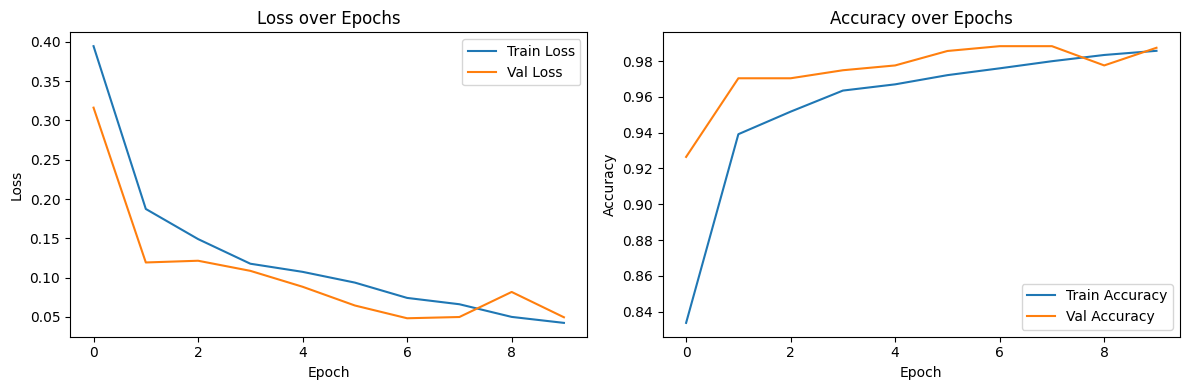

In [ ]:
# training
model = RNNClassifier(vocab_size=len(stoi), hidden_size=128, rnn_type='GRU')
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, num_epochs=10)
plot_training_curves(train_losses, val_losses, train_accs, val_accs)


### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

##### Model 1 - Max Pooling

**Hyperparameter**: Pooling strategy

Switched from concatenated max + mean pooling (used in Model 0) to only max pooling across the RNN outputs.

**Best Validatiin Accuracy**: 0.9803, did NOT improve from Model 0's 0.9883

**Reason**:
Compared to max + mean pooling, this approach reduces the representation size (by half) and removes redundant averaging, potentially improving efficiency.

However, the validation accuracy slightly dropped, suggesting that combining max and mean pooling helps retain both strong features and broader context.

In [ ]:
class RNNMaxPoolModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, rnn_type='GRU'):
        super().__init__()
        self.encoder = CharOneHotEncoder(vocab_size)

        if rnn_type == 'GRU':
            self.rnn = nn.GRU(vocab_size, hidden_size, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(vocab_size, hidden_size, batch_first=True)
        elif rnn_type == 'RNN':
            self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        else:
            raise ValueError("Unsupported RNN type")

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.encoder(x)
        out, _ = self.rnn(x)

        # Max pooling only
        pooled = torch.max(out, dim=1)[0]

        return torch.sigmoid(self.fc(pooled)).squeeze(1)


In [ ]:
# train
model1 = RNNMaxPoolModel(vocab_size=len(stoi), hidden_size=128, rnn_type='GRU')
train_losses, val_losses, train_accs, val_accs = train_model(model1, train_loader, val_loader, num_epochs=10)


Epoch 1: train_loss=0.3444, train_acc=0.8622, val_loss=0.1547, val_acc=0.9614
Epoch 2: train_loss=0.2914, train_acc=0.9040, val_loss=0.1434, val_acc=0.9695
Epoch 3: train_loss=0.3261, train_acc=0.8861, val_loss=0.1220, val_acc=0.9534
Epoch 4: train_loss=0.1943, train_acc=0.9267, val_loss=0.3307, val_acc=0.8368
Epoch 5: train_loss=0.1673, train_acc=0.9460, val_loss=0.1045, val_acc=0.9516
Epoch 6: train_loss=0.1215, train_acc=0.9589, val_loss=0.1025, val_acc=0.9650
Epoch 7: train_loss=0.1093, train_acc=0.9634, val_loss=0.0882, val_acc=0.9686
Epoch 8: train_loss=0.0978, train_acc=0.9692, val_loss=0.0748, val_acc=0.9803
Epoch 9: train_loss=0.0959, train_acc=0.9682, val_loss=0.1216, val_acc=0.9623
Epoch 10: train_loss=0.1423, train_acc=0.9559, val_loss=0.1033, val_acc=0.9776


##### Model 2 - LSTM


**Hyperparameter**: RNN cell type
Switched from a GRU (used in Model 0) to an LSTM as the recurrent unit within the RNN model.

**Best Validatiin Accuracy**: 0.9785, did NOT improve from Model 0's 0.9883

**Reason**:
LSTM cells introduce an additional memory component (the cell state) that may help capture longer-term dependencies in sequence data. It might improve performance on messages with distant contextual clues.

In [ ]:
model2 = RNNClassifier(vocab_size=len(stoi), hidden_size=128, rnn_type='LSTM')
train_losses2, val_losses2, train_accs2, val_accs2 = train_model(
    model2,
    train_loader,
    val_loader,
    num_epochs=10,
)


Epoch 1: train_loss=0.4428, train_acc=0.8418, val_loss=0.1725, val_acc=0.9641
Epoch 2: train_loss=0.3100, train_acc=0.9010, val_loss=0.4148, val_acc=0.8655
Epoch 3: train_loss=0.4528, train_acc=0.7996, val_loss=0.3045, val_acc=0.9067
Epoch 4: train_loss=0.2282, train_acc=0.9350, val_loss=0.1939, val_acc=0.9363
Epoch 5: train_loss=0.1606, train_acc=0.9546, val_loss=0.1383, val_acc=0.9534
Epoch 6: train_loss=0.1719, train_acc=0.9406, val_loss=0.1059, val_acc=0.9614
Epoch 7: train_loss=0.1270, train_acc=0.9607, val_loss=0.2021, val_acc=0.9058
Epoch 8: train_loss=0.1527, train_acc=0.9433, val_loss=0.1086, val_acc=0.9641
Epoch 9: train_loss=0.1108, train_acc=0.9649, val_loss=0.0799, val_acc=0.9713
Epoch 10: train_loss=0.0927, train_acc=0.9695, val_loss=0.0607, val_acc=0.9785


##### Model 3 - Hidden size 256


**Hyperparameter**: Hidden size

Increased the RNN hidden dimension from 128 (used in Model 0) to 256 to explore whether a larger model capacity improves performance.

**Best Validatiin Accuracy**: 0.9865, did NOT improve from Model 0's 0.9883

**Reason**:
Larger hidden sizes provide the model with more capacity to learn complex patterns by expanding the dimensionality of the hidden state. This can help the model better capture subtle relationships in the data, especially in longer or more varied input sequences.

In [ ]:
class RNNClassifierHidden(nn.Module):
    # change hidden_size to 256v (from 128 in Model 0)
    def __init__(self, vocab_size, hidden_size=256, rnn_type='GRU'):
        super().__init__()
        self.encoder = CharOneHotEncoder(vocab_size)

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(vocab_size, hidden_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(vocab_size, hidden_size, batch_first=True)
        else:
            raise ValueError("Unsupported RNN type")

        # After concatenating max and mean pool: hidden_size * 2 → 1 output
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # x: (batch_size, seq_len) of character indices
        x = self.encoder(x)

        out, _ = self.rnn(x)

        # max and mean pooling
        max_pool = torch.max(out, dim=1)[0]
        mean_pool = torch.mean(out, dim=1)
        pooled = torch.cat([max_pool, mean_pool], dim=1)

        return torch.sigmoid(self.fc(pooled)).squeeze(1)


In [ ]:
model3 = RNNClassifier(vocab_size=len(stoi), hidden_size=256, rnn_type='GRU')
train_losses3, val_losses3, train_accs3, val_accs3 = train_model(
    model3,
    train_loader,
    val_loader,
    num_epochs=10,
)


Epoch 1: train_loss=0.3432, train_acc=0.8670, val_loss=0.1263, val_acc=0.9776
Epoch 2: train_loss=0.1476, train_acc=0.9504, val_loss=0.0692, val_acc=0.9821
Epoch 3: train_loss=0.1069, train_acc=0.9662, val_loss=0.0720, val_acc=0.9830
Epoch 4: train_loss=0.0869, train_acc=0.9740, val_loss=0.1190, val_acc=0.9596
Epoch 5: train_loss=0.0745, train_acc=0.9775, val_loss=0.0581, val_acc=0.9865
Epoch 6: train_loss=0.0516, train_acc=0.9859, val_loss=0.0512, val_acc=0.9821
Epoch 7: train_loss=0.0498, train_acc=0.9851, val_loss=0.0657, val_acc=0.9821
Epoch 8: train_loss=0.0364, train_acc=0.9886, val_loss=0.0783, val_acc=0.9794
Epoch 9: train_loss=0.0304, train_acc=0.9902, val_loss=0.0660, val_acc=0.9821
Epoch 10: train_loss=0.0224, train_acc=0.9927, val_loss=0.0609, val_acc=0.9830


##### Model 4 - Smaller learning rate 1e-4


**Hyperparameter**: Learning rate

Reduced the learning rate from the default 1e-3 (used in Model 0) to 1e-4 while keeping all other hyprparameters the same.

**Best Validatiin Accuracy**: 0.9659, did NOT improve from Model 0's 0.9883

**Reason**:
A smaller learning rate slows down the weight updates, which can help the model converge more smoothly and avoid overshooting local minima. This is often useful in preventing overfitting or improving generalization, especially in deeper or noisier models.

In [ ]:
model4 = RNNClassifier(vocab_size=len(stoi), hidden_size=128, rnn_type='GRU')

train_losses4, val_losses4, train_accs4, val_accs4 = train_model(
    model4,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=1e-4,  # smaller learning rate
)


Epoch 1: train_loss=0.6399, train_acc=0.7437, val_loss=0.4018, val_acc=0.8484
Epoch 2: train_loss=0.3501, train_acc=0.8705, val_loss=0.4411, val_acc=0.8906
Epoch 3: train_loss=0.3462, train_acc=0.8593, val_loss=0.2755, val_acc=0.9274
Epoch 4: train_loss=0.2380, train_acc=0.9246, val_loss=0.2135, val_acc=0.9632
Epoch 5: train_loss=0.2066, train_acc=0.9403, val_loss=0.2003, val_acc=0.9578
Epoch 6: train_loss=0.1931, train_acc=0.9435, val_loss=0.2122, val_acc=0.9596
Epoch 7: train_loss=0.1880, train_acc=0.9436, val_loss=0.1998, val_acc=0.9596
Epoch 8: train_loss=0.2483, train_acc=0.9181, val_loss=0.2048, val_acc=0.9614
Epoch 9: train_loss=0.2142, train_acc=0.9289, val_loss=0.2057, val_acc=0.9641
Epoch 10: train_loss=0.2353, train_acc=0.9360, val_loss=0.1669, val_acc=0.9659


### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.


Final Model: Model 0


- **False Positives**: model predicted 1 (spam) when the true label was 0 (ham) = % of negative samples incorrectly predicted as positive

- **False Negatives**: model predicted 0 (ham) when the true label was 1 (spam) = % of positive samples incorrectly predicted as negative

In [ ]:
def compute_fpr_fnr(model, data_loader, device='cpu'):
    model.eval()
    model.to(device)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            preds = (outputs > 0.5).long()

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    neg_mask = y_true == 0   # locations where the true label is ham (0)
    pos_mask = y_true == 1   # locations where the true label is spam (1)

    false_positives = np.sum((y_pred == 1) & neg_mask)
    false_negatives = np.sum((y_pred == 0) & pos_mask)

    total_neg = np.sum(neg_mask)
    total_pos = np.sum(pos_mask)

    fpr = false_positives / total_neg
    fnr = false_negatives / total_pos

    return fpr, fnr


In [ ]:
fpr, fnr = compute_fpr_fnr(model, val_loader, device='cpu')
print(f"False Positive Rate: {fpr:.4f}")
print(f"False Negative Rate: {fnr:.4f}")


False Positive Rate: 0.0083
False Negative Rate: 0.0400


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**False Positive** (ham misclassified as spam):
This means an important legitimate message (e.g., from a friend, family member, or service provider) is mistakenly filtered into the spam folder.

For the user, this could result in missing critical or time-sensitive information, like an appointment reminder, job interview notice, or bank alert.

**False Negative** (spam misclassified as ham):
This allows an unwanted spam message to appear in the user’s main inbox. While this may be annoying and slightly reduce trust in the filtering system, **it is generally less severe than a false positive.** The user can manually recognize and delete the spam.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_acc = get_accuracy(model, test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.9740


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
fpr_test, fnr_test = compute_fpr_fnr(model, test_loader, device='cpu')
print(f"False Positive Rate: {fpr_test:.4f}")
print(f"False Negative Rate: {fnr_test:.4f}")


False Positive Rate: 0.0186
False Negative Rate: 0.0738


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

In [ ]:
msg = "machine learning is sooo cool!"

# char look up using stoi
indices = [stoi[c] for c in msg if c in stoi]

# convert indices to tensor
input_tensor = torch.tensor(indices).unsqueeze(0)  # shape (1, seq_len)

input_tensor = input_tensor.to('cpu')

model.eval()

with torch.no_grad():
    prob = model(input_tensor).item()

print(f"Spam probability: {prob:.4f}")


Spam probability: 0.2369


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

1. **Is detecting spam an easy or difficult task?**

Detecting spam is moderately difficult. While some spam messages contain obvious patterns, others are more subtle, mimicking legitimate communication. Additionally, language evolves, and spammers constantly adapt their techniques. Therefore, spam detection systems need to handle ambiguous messages, varied writing styles, and evolving vocabularies, which makes the task more complex than it may seem.

2. **Baseline Model: logistic regression**

**Steps**:

- Preprocessing: Lowercase text, tokenize, and vectorize to get fixed-length input vectors.

- Model: Use a single linear layer (i.e. logistic regression): Linear(input_dim, 1) + sigmoid.

- Training: Use binary cross-entropy loss with SGD or Adam; train for a few epochs (eg. 10 epochs).

- Prediction: Vectorize the message and predict spam if probability > 0.5.

**Advantages**:

- Fast to train: No need for GPU or long training cycles.

- Interpretable: Can examine learned weights to see which tokens are most indicative of spam.

